We used this notebook as a base to develop notebooks to compare on the original "flat" lat/lon grid. 

It was used to compare the effects of 

- standardization
- dataset splits
- precipitation weighting

in the Appendix of the thesis.

In the current state it is fit for precipitation weighting. With small modifications also the other two experiments can be reproduced.

In [59]:
import os
import glob

import numpy as np
import math

import copy
import re
from datetime import datetime

import gzip
import netCDF4 as nc
import pickle

from braceexpand import braceexpand
from fnmatch import fnmatch

import matplotlib.pyplot as plt
import matplotlib 


import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [60]:
DIRECTORY_DATASETS_INTERPOLATED = "Datasets/Interpolated/"
DIRECTORY_DATASETS_ORIGINAL = "Datasets/Original/"
DIRECTORY_IMAGES = "Images/"
DIRECTORY_OUTPUTS = "Output/Compare_UNet_architectures/"

# Give criteria for the dataset and open all files that match these criteria

In [61]:
def braced_glob(path):
    l = []
    for x in braceexpand(path):
        l.extend(glob.glob(x))
    return l

In [78]:
# dataset parameters. To leave unspecified use: "*"
PREFIX = "HadCM3-flat"
DO_SHUFFLE = False
ALL_VARIABLES = np.sort(["temp_1","precip","dO18"])#np.sort(["temp_1","precip","dO18"])  # "*" get all possible combinations 
DSET_NR = "*"
# helping vars
shuffle_dict = {True:"shuffle", False:"no-shuffle", "*": "*"}

# wildcards can be used in this filename.
DATASET_FOLDER = "{}_{}_{}_".format(PREFIX, "*", DSET_NR)#shuffle_dict[DO_SHUFFLE]
DATASET_FOLDER = DATASET_FOLDER + "-".join(ALL_VARIABLES) # using "*" + "-".join(ALL_VARIABLES) instead of DATASET_FOLDER + ... makes it possible to use ico folders too.

DATASET_FOLDER = os.path.join(DIRECTORY_OUTPUTS, DATASET_FOLDER)


dataset_description_files = []  # list to collect the paths to the configuration files
dataset_folders = []  # list to collect all the matching folders.
folder_exists = False

print("Data folders matching the given specifications:")
for dirname in braced_glob(DATASET_FOLDER):
    print(dirname)
    folder_exists = True
    dataset_folders.append(dirname)
    dataset_description_files.append(os.path.join(dirname, "dataset-description.gz"))
if folder_exists == False:
    raise OSError("There exists no folder for the given specifications")

dataset_descriptions = []
for i, file in enumerate(dataset_description_files):
    with gzip.open(file, 'rb') as f:
        dataset_descriptions.append(pickle.load(f))

Data folders matching the given specifications:
Output/Compare_UNet_architectures/HadCM3-flat_no-shuffle_1_dO18-precip-temp_1


In [79]:
def check_dict_conditions(dic, conditions):
    """
    Test whether dict "dic" fullfills the given conditions "conditions". 
    The latter are given as a array of key-value pairs.
    """
    for key, values in conditions:
        if key in dic.keys():
            if not dic[key] in values:
                return False
        else:
            return False
    return True

In [80]:
model_descriptions = []
testset_predictions = []
indices_dataset = [] # store the index of the dataset-directory to which each run belongs
model_descriptions_paths = []
valid_dirs = []

# specify the conditions that we want the runs to match
conditions = [("MODELTYPE", ("Classical_flat_PCA","Classical_flat_LinReg"))]#("loss", "MSELoss"),("USE_CYLINDRICAL_PADDING",  True),("USE_COORD_CONV", True), ("S_MODE_TARGETS", ('Pixelwise',))]
               #, ("RUN_NR",1), ("USE_CYLINDRICAL_PADDING",  False),
              #("USE_COORD_CONV", False)]# [("MODELTYPE", "Classical")]


print("Available runs from all previously specified folders, that match specifications:")

for i, dataset_folder in enumerate(dataset_folders):
    subdirs = [d for d in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, d))]
    for subdir in subdirs:
        files = [f for f in os.listdir(os.path.join(dataset_folder, subdir)) if os.path.isfile(os.path.join(dataset_folder, subdir, f))]
        if "model_training_description.gz" in files and "predictions.gz" in files:        
            # this is a valid description of a model run. Store path and print description
            with gzip.open(os.path.join(dataset_folder, subdir, "model_training_description.gz"), 'rb') as f:
                tmp_description = pickle.load(f)
                if check_dict_conditions(tmp_description, conditions):  # check if the description satisfies our conditions
                    model_descriptions.append(tmp_description)      
                    indices_dataset.append(i)
                    model_descriptions_paths.append(os.path.join(dataset_folder, subdir, "model_training_description.gz"))
                    print("Path: ", subdir)
                    # for key, value in model_descriptions[-1].items():
                        # print(key,": ", value)
                    print("\n")
                    if tmp_description["MODELTYPE"] == "UNet":  # if we open a run that was interpolated from an ico grid...
                        fi = os.path.dirname(model_descriptions_paths[-1])
                        tmp_dset = nc.Dataset(fi + "_6_nbs_r_5_nbs_6_cons1.nc")
                        testset_predictions.append(np.array(tmp_dset.variables["dO18"][:])[:,1:-1,:])
                    with gzip.open(os.path.join(dataset_folder, subdir, "predictions.gz"), 'rb') as g:
                        testset_predictions.append(pickle.load(g))       
            valid_dirs.append(i)
        else:
            print("Encountered Invalid directory")

Available runs from all previously specified folders, that match specifications:
Encountered Invalid directory
Path:  classical_linreg-0x4a61332024b51541


Path:  classical_pca_0x6ac74c55bb50f2d




Check that we can handle the specified target variable and collect the required files.

In [82]:
required_files = []
precip_files = []
for i, description in enumerate(dataset_descriptions):
    # print("Target variable:", description["target_variables"])
    if description["target_variables"] == ["dO18"]:
        required_files.append([])
        precip_files.append([])
        for filename in description["files_used"]:
            if "isotopes" in filename:
                required_files[-1].append(filename)
            if "precip" in filename:
                precip_files[-1].append(filename)
    else:
        raise NotImplementedError("Currently only d18O is a valid target variable.")

# Load data, especially ground truth data

In [83]:
def precip_weighted_yearmon_mean(dataset_path, var_name, precip_path):
    """
    Given the name of the variable and the file where to find it, compute its yearly precip-weighted average value.
    In the yearly average we want to ignore nan's if they occur.
    Assumes that the time-dimension is the first dim: shape = (n_timesteps,...) and that there are no missing/invalid 
    values for precip.
    
    If the variable is precip itself, we just return the (unweighted) average.
    """
    var_dset = nc.Dataset(dataset_path)
    var = var_dset.variables[var_name]
    var_monthly_data = var[:].data
    missing_value = var.missing_value
    var_monthly_data[var_monthly_data==missing_value] = np.nan
    
    precip_dset = nc.Dataset(precip_path)
    precip = precip_dset.variables["precip"]
    precip_monthly_data = precip[:].data
    
    assert precip_monthly_data.shape == var_monthly_data.shape
    
    # make sure that both datasets use the same timeaxis and have the same timestamps
    assert var_dset.variables["t"].calendar == precip_dset.variables["t"].calendar == "360_day"
    assert var_dset.variables["t"].units == precip_dset.variables["t"].units
    assert (var_dset.variables["t"][:] == precip_dset.variables["t"][:]).all()
    
    
    t = precip_dset.variables["t"][:].data
    t_0 = t[0]
    match = re.search(r'\d{4}-\d{2}-\d{2}', precip_dset.variables["t"].units)
    if match is None:
        raise ValueError("No date following the YYY-MM-DD convention found")
    ref_date = datetime.strptime(match.group(), '%Y-%m-%d').date()

    ref_year = ref_date.year
    ref_month = ref_date.month - 1  # months in calendar 1-12, we want 0-11
    ref_day = ref_date.day

    d_year = t_0 // 360
    d_month = (t_0 - d_year*360) // 30
    d_day = (t_0 - d_year*360 - d_month*30) // 1

    d_0 = (ref_day + d_day) % 30
    m_0 = (ref_month + d_month + (ref_day+d_day)//30) % 12
    y_0 = ref_year + d_year + (ref_month + d_month + (ref_day+d_day)//30)//12
    
    t_yr = np.zeros_like(t) # what year are we in in the current screenshot compared to y_0?
    for i in range(len(t)):
        t_year = t[i] // 360
        t_month = (t[i] - t_year*360) // 30
        t_day = (t[i] - t_year*360 - t_month*30) // 1        
        t_yr[i] = (t_year - d_year) + (ref_month + t_month + (ref_day+t_day)//30)//12
    t_yr = t_yr.astype("int")    
    n_years = np.amax(t_yr)+1 
    
    # create weights from precip and masks to deal with nans
    weights = precip_monthly_data
    masked_var = np.ma.MaskedArray(var_monthly_data, mask=np.isnan(var_monthly_data))
    var_yearly_data = np.ma.zeros((n_years, *var_monthly_data.shape[1:]))
    
    if var_name == "precip":
        for i in range(n_years):
            i_mask = (t_yr==i)
            var_yearly_data[i,...] = np.ma.average(masked_var[i_mask,...], axis=0)        
    else:
        for i in range(n_years):
            i_mask = (t_yr==i)
            var_yearly_data[i,...] = np.ma.average(masked_var[i_mask,...], weights=weights[i_mask,...], axis=0)
            
    res = copy.deepcopy(var_yearly_data.data)
    res[var_yearly_data.mask] = np.nan
    return res

In [84]:
# names of datasets to which we want not to be missing at any timestep.
dnames = [DIRECTORY_DATASETS_ORIGINAL+"xnapa_isotopes.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_precip.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_slp.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_temp.nc"]

def get_shared_timesteps(dataset_names):
    """
    Not all datasets share the same timesteps. The biggest problems occur in the slp dataset. We want to exclude all
    time steps where one of the variables is missing
    """
    
    # get indices of elements that are shared for all variables.
    from functools import reduce
    ts = tuple([nc.Dataset(dataset_name,"a").variables["t"][:].data for dataset_name in dataset_names])
    common_dates = reduce(np.intersect1d, ts)
    
    return common_dates

In [85]:
isotopes_all_datasets = []
isotopes_yearly_all_datasets = []
for i in range(len(dataset_descriptions)):
    isotopes_all_datasets.append(nc.Dataset(required_files[i][0], "a"))
    if "monthly" in required_files[i][0]:
        isotopes_yearly_all_datasets.append(nc.Dataset(required_files[i][0].replace("monthly_",""), "a"))
    else:
        isotopes_yearly_all_datasets.append([])

d18O = []

lat = []
lon = []

for i, (dataset, yearly_dataset) in enumerate(zip(isotopes_all_datasets, isotopes_yearly_all_datasets)):
    if "monthly" in required_files[i][0]:
        lat.append(dataset.variables["latitude"][:].data[1:-1])
        lon.append(dataset.variables["longitude"][:])
        
        c_dates = get_shared_timesteps(dnames)
        # get the corresponding indices:
        indices = []
        for k, t in enumerate(yearly_dataset.variables["t"][:].data):
            if t in c_dates:
                indices.append(k)
        indices = np.array(indices)
        index_mask = np.logical_and(yearly_dataset.variables["t"][indices].data // 360 >= 654, \
                                    yearly_dataset.variables["t"][indices].data // 360 < 1654)    
        indices = indices[index_mask]  
        
        # only works if d18O and precip available in any case - 
        # this is always the case where we want to do precip weighting though        
        tmp = precip_weighted_yearmon_mean(required_files[i][0], "dO18", precip_files[i][0])
        d18O.append(np.squeeze(tmp)[indices,1:-1,:])
    else:
        print()
        lat.append(dataset.variables["latitude"][:].data[1:-1])
        lon.append(dataset.variables["longitude"][:])
        
        c_dates = get_shared_timesteps(dnames)
        # get the corresponding indices:
        indices = []
        for j, t in enumerate(dataset.variables["t"][:].data):
            if t in c_dates:
                indices.append(j)
        indices = np.array(indices)
        index_mask = np.logical_and(dataset.variables["t"][indices].data // 360 >= 654, \
                                    dataset.variables["t"][indices].data // 360 < 1654)    
        indices = indices[index_mask]  
        
        d18O.append(np.squeeze(dataset.variables["dO18"][:].data)[indices,1:-1])

In [86]:
d18O_train = []

d18O_test = []

for i, description in enumerate(dataset_descriptions):
    d18O_train.append(d18O[i][description["indices_train"],...])

    d18O_test.append(d18O[i][description["indices_test"],...])

In [87]:
# in order to compare with the original dataset 
# we need to rescale the prediction based on the standardization that we used in the model

rescaled_predictions = []

for i, description in enumerate(model_descriptions):
    rescaled_predictions.append([])
    for j, mode in enumerate(description["S_MODE_TARGETS"]):
        if mode == "Global":
            std = np.mean(np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True), axis=(1,2), keepdims=True)
            std[std==0] = 1
            mean = np.mean(d18O_train[indices_dataset[i]], axis=(0,1,2), keepdims=True)
            rescaled_predictions[-1].append((testset_predictions[i]["predictions"][:,j,...] * std) + mean)             
        elif mode == "Pixelwise":        
            std = np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
            std[std==0] = 1
            mean = np.mean(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
            rescaled_predictions[-1].append((testset_predictions[i]["predictions"][:,j,...] * std) + mean)   
        elif mode == "Global_mean_pixelwise_std":
            std = np.mean(np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True), axis=(1,2), keepdims=True)
            std[std==0] = 1
            mean = np.mean(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
            rescaled_predictions[-1].append((testset_predictions[i]["predictions"][:,j,...] * std) + mean)           
        elif mode == "Pixelwise_mean_global_std":
            std = np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
            std[std==0] = 1
            mean = np.mean(d18O_train[indices_dataset[i]], axis=(0,1,2), keepdims=True)
            rescaled_predictions[-1].append((testset_predictions[i]["predictions"][:,j,...] * std) + mean)  
        elif mode == "None":
            rescaled_predictions[-1].append(testset_predictions[i]["predictions"])
        else:
            raise NotImplementedError("{} is not a valid keyword for standardization".format(mode))
    rescaled_predictions[-1] = np.stack(rescaled_predictions[-1],axis=1)

# Plotting

In [88]:
def plot_regular_lattice_map(data, lat, lon, cmap=None, norm=None, show_continents=True, 
                         figsize=(15,10), projection=ccrs.Robinson(), savename=None):
    """
    Plot a single image given in standard. Assume shape is (lat,lon).
    """
    assert len(data.shape) == 2

    if cmap is None:
        cmap = plt.get_cmap("plasma")
    if norm is None:
        dmin = np.amin(data)
        dmax = np.amax(data)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.set_global()
    #remove white line
    data, lon_plot = add_cyclic_point(data, coord = lon)
    lo, la = np.meshgrid(lon_plot, lat)
    layer = ax.pcolormesh(lo, la, data, transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)    
    
    ax.coastlines(alpha=0.5)
    if savename is not None:
        plt.savefig(DIRECTORY_IMAGES+savename)
    plt.show()

In [89]:
# calibrate colorscale such that all simulations share the same min and max
vmin = min([np.amin(r_pred[0]) for r_pred in rescaled_predictions] + [np.amin(gt[0]) for gt in d18O_test])
vmax = max([np.amax(r_pred[0]) for r_pred in rescaled_predictions] + [np.amax(gt[0]) for gt in d18O_test])

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

In [90]:
"""
for i, i_j in enumerate(indices_dataset):
    print(i)
    # for key, value in dataset_descriptions[i_j].items():
        # print(key,": ", value)
    for key, value in model_descriptions[i].items():
        print(key,": ", value)
    plot_regular_lattice_map(rescaled_predictions[i][0,0,...], lat[indices_dataset[i]], lon[indices_dataset[i]], norm=norm)
"""
print("uncomment this to get sample rescaled predictions from each run")

uncomment this to get sample rescaled predictions from each run


In [91]:
def RMSE(predictions, targets):
    from sklearn.metrics import mean_squared_error
    rmse = np.zeros((predictions.shape[1]))
    for i in range(predictions.shape[1]):
        rmse[i] = mean_squared_error(targets[:,i], predictions[:,i], squared=False)
    return rmse

In [92]:
rmse = []
metric = []
for i in range(len(rescaled_predictions)):
    rmse.append(RMSE(d18O_test[indices_dataset[i]].reshape(d18O_test[indices_dataset[i]].shape[0],-1), \
                     rescaled_predictions[i].reshape(rescaled_predictions[i].shape[0],-1)).reshape(len(lat[indices_dataset[i]]), len(lon[indices_dataset[i]])))

    # compute explained variance by dividing rmse by standard-deviation on test set.
    metric.append(- rmse[-1]/np.std(d18O_test[indices_dataset[i]], axis=0).reshape(len(lat[indices_dataset[i]]), len(lon[indices_dataset[i]])) + 1 )

In [93]:
def plot_explained_variance(metric, lat, lon, figsize=(15,10), cbar_fontsize=15, projection=ccrs.Robinson(), 
                            title="", cbar_label="", norm=None, cmap=None, title_fontsize=15, savename=None, use_default_bounds=True):
    # plot RMSE/sigma - 1
    assert metric.shape == (len(lat), len(lon))
    
    #set up colormap
    colors = ["#67001f","#b2182b","#d6604d","#f4a582","#fddbc7","#d1e5f0","#92c5de","#4393c3","#2166ac","#053061"]
    
    if use_default_bounds:
        lim = 1 # math.ceil(np.max(metric))
        bounds = np.concatenate((np.array([-1.0,-0.8,-0.6,-0.4,-0.2]),np.linspace(0, lim, 6)))
    if cmap is None:
        cmap= matplotlib.colors.ListedColormap(colors)
    if norm is None:
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
                          
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1,projection = projection)
    ax.set_global()
    #remove white line
    field, lon_plot = add_cyclic_point(metric, coord = lon)
    lo, la = np.meshgrid(lon_plot, lat)
    layer = ax.pcolormesh(lo, la, field, transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
    
    if use_default_bounds:
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
            ticks=bounds,
            spacing='proportional',
            orientation='horizontal',
            label='Discrete intervals, some other units',
        ) 
    else:
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
            spacing='proportional',
            orientation='horizontal',
            label='Discrete intervals, some other units',
        )        
    if cbar_label == "":
        cbar.set_label(r"$R^2$ score", fontsize = cbar_fontsize)
    else:
        cbar.set_label(cbar_label, fontsize = cbar_fontsize)
        
    cbar.ax.tick_params(labelsize=20)
    
    ax.coastlines()

    # calculate the global average metric
    weights = np.tile(np.cos(np.deg2rad(lat))[:,None],len(lon))
    metric_global_av = np.average(metric, weights = weights)
    if title == "":
        ax.set_title(r"$R^2$ score, " + \
                     "Global area weighted average: {:.3f}".format(metric_global_av), fontsize=title_fontsize)
    else:
        ax.set_title(title, fontsize=title_fontsize)
        
    if savename is not None:
        plt.savefig(DIRECTORY_IMAGES+savename)

In [94]:
"""
for i in range(len(metric)):
    print(model_descriptions[i]["RUN_NR"])
    print(model_descriptions[i]["S_MODE_PREDICTORS"])    
    print(model_descriptions[i]["S_MODE_TARGETS"])
    print(dataset_descriptions[indices_dataset[i]]["predictor_variables"])
    
    print(model_descriptions[i]["USE_CYLINDRICAL_PADDING"])
    print(model_descriptions[i]["USE_COORD_CONV"])
    print(model_descriptions[i]["loss"])
    plot_explained_variance(metric[i], lat[indices_dataset[i]],lon[indices_dataset[i]], savename="flat_coord_conv_{}.jpg".format(i))
    plt.show()
"""
print("uncomment this to get rescaled variance for each run.")

uncomment this to get rescaled variance for each run.


# Calculate averages over many runs

In [100]:
# if things that we want to average are not automatically ordered...

groups = []
indices_groups = []

for i in range(len(model_descriptions)):
    
    matches_group = np.array([model_descriptions[i]["MODELTYPE"]  == model_descriptions[group]["MODELTYPE"] for group in groups])
    """
    matches_group = np.array([dataset_descriptions[indices_dataset[i]]["DO_SHUFFLE"] and dataset_descriptions[indices_dataset[group]]["DO_SHUFFLE"] and \
                              dataset_descriptions[indices_dataset[i]]["DSET_NB"] and dataset_descriptions[indices_dataset[group]]["DSET_NB"]])
    """    
    if matches_group.any():
        indices_groups[np.where(matches_group == True)[0][0]].append(i)
        
    else:
        groups.append(i)
        indices_groups.append([])
        indices_groups[-1].append(i)
        
av_metric = np.zeros((len(groups),*metric[0].shape))
global_mean = np.zeros(len(groups))
global_std = np.zeros(len(groups))
# calculate global means and their standard deviations
for i in range(len(groups)):
    l = len(indices_groups[i])
    group_data = np.zeros((l, *metric[0].shape))
    for j, i_g in enumerate(indices_groups[i]):
        group_data[j] = metric[i_g]
    av_metric[i] = np.average(group_data, axis=0)
    
    weights = np.repeat(np.tile(np.cos(np.deg2rad(lat[0]))[:,None],len(lon[0]))[np.newaxis,...], repeats=l, axis=0)
    global_av_metric = np.average(group_data, weights = weights, axis=(1,2))
    global_mean[i] = np.mean(global_av_metric)
    global_std[i] = np.std(global_av_metric)

In [101]:
weights = np.tile(np.cos(np.deg2rad(lat[0]))[:,None],len(lon[0]))
global_av_metric = np.zeros((av_metric.shape[0]))
for i in range(len(global_av_metric)):
    global_av_metric[i] = np.average(av_metric[i,...], weights = weights)

MODELTYPE Classical_flat_LinReg
0.169 +/- 0.000


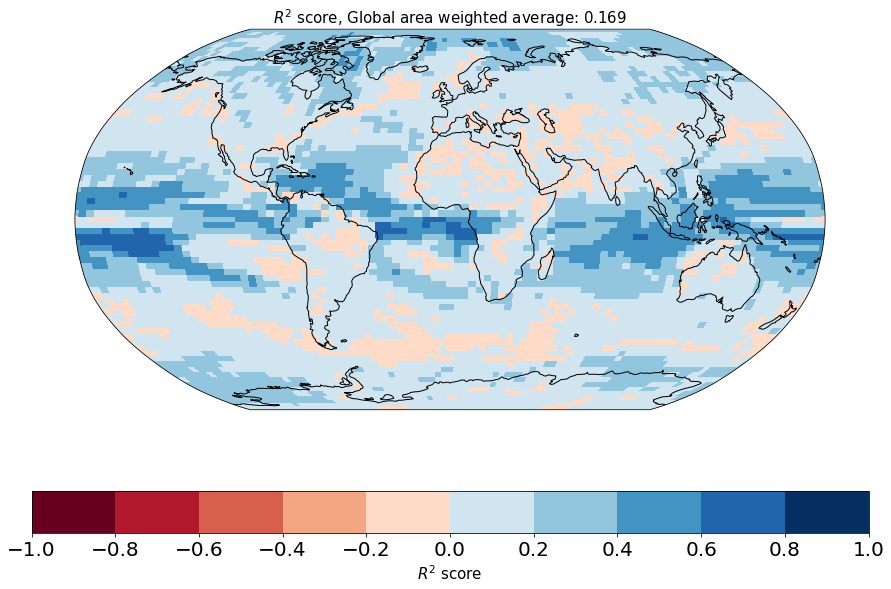

MODELTYPE Classical_flat_PCA
0.175 +/- 0.000


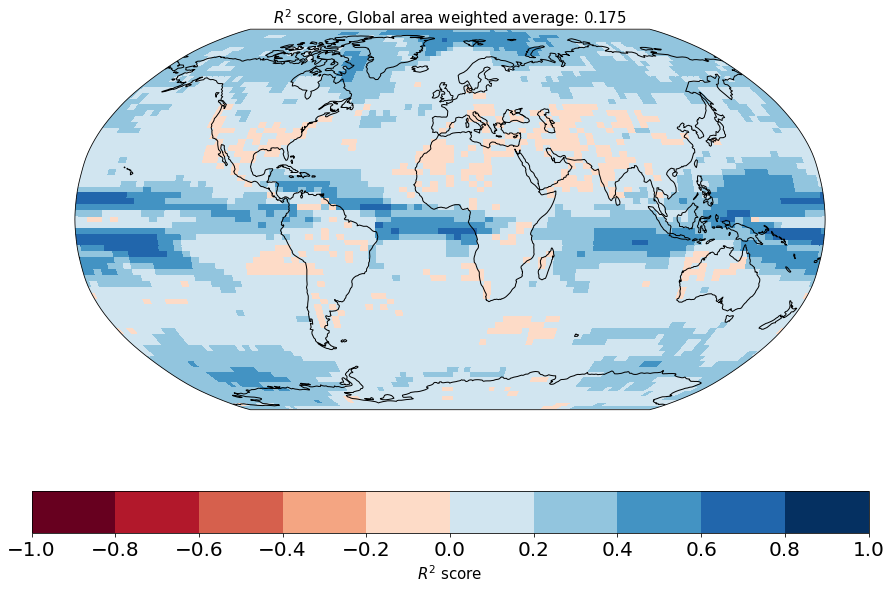

In [103]:
for i, g in enumerate(groups):
    print("MODELTYPE", model_descriptions[g]["MODELTYPE"])    
    # print("LEARNING_RATE", model_descriptions[g]["LEARNING_RATE"])   
    print("{:.3f}".format(global_mean[i]), "+/-", "{:.3f}".format(global_std[i]))
    plot_explained_variance(av_metric[i], lat[indices_dataset[g]],lon[indices_dataset[g]])#, savename="flat_coord_conv_{}.jpg".format(i))
    plt.show()